# PROYECTO INDIVIDUAL N°1 - Machine Learning Operations (MLOps)

# *Parte 2 - MLOps*

In [1]:
# Importamos la libreria pandas
import pandas as pd

In [2]:
# Cargamos los datos transformados de la parte 1 (Data Engineer)
df = pd.read_csv('datos_streaming_transformados.csv')
df.head(3)

,id,plataforma,type,title,director,cast,country,date_added,release_year,rating_x,duration_int,duration_type,listed_in,description,userId,scored,timestamp
0,as1,amazon,movie,the grand seduction,don mckellar,"brendan gleeson, taylor kitsch, gordon pinsent",canada,2021-03-30,2014,g,113,min,"comedy, drama",a small fishing village must procure a local d...,99178.6,3.5,1.173241e+09
1,as2,amazon,movie,take care good night,girish joshi,"mahesh manjrekar, abhay mahajan, sachin khedekar",india,2021-03-30,2018,13+,110,min,"drama, international",a metro family decides to fight a cyber crimin...,93837.5,3.5,1.168607e+09
2,as3,amazon,movie,secrets of deception,josh webber,"tom sizemore, lorenzo lamas, robert lasardo, r...",united states,2021-03-30,2017,g,74,min,"action, drama, suspense",after a man discovers his wife is cheating on ...,84095.3,3.5,1.176941e+09


### _Análisis Exploratorio De Los Datos_

In [3]:
# Revisamos los tipos de datos del dataset
print ('Tipos de datos:')
print(df.dtypes)
print('-----------------------------------------------------------------------------')

# Verificamos si hay valores faltantes
print('Cantidad de valores faltantes:')
print(df.isnull().sum())
print('-----------------------------------------------------------------------------')

# Verificamos si hay valores duplicados
print('Cantidad de valores duplicados:')
print(df.duplicated().sum())
print('-----------------------------------------------------------------------------')

# Realizamos un resumen estadístico del dataset
print('Resumen estadistico:')
print(df.describe())

Tipos de datos:
id                object
plataforma        object
type              object
title             object
director          object
cast              object
country           object
date_added        object
release_year       int64
rating_x          object
duration_int       int64
duration_type     object
listed_in         object
description       object
userId           float64
scored           float64
timestamp        float64
dtype: object
-----------------------------------------------------------------------------
Cantidad de valores faltantes:
id                   0
plataforma           0
type                 0
title                0
director          8259
cast              5321
country          11499
date_added        9554
release_year         0
rating_x             0
duration_int         0
duration_type      482
listed_in            0
description          4
userId               0
scored               0
timestamp            0
dtype: int64
--------------------------------

In [4]:
# Importamos librerias para vizualizar los datos
import seaborn as sns
import matplotlib.pyplot as plt

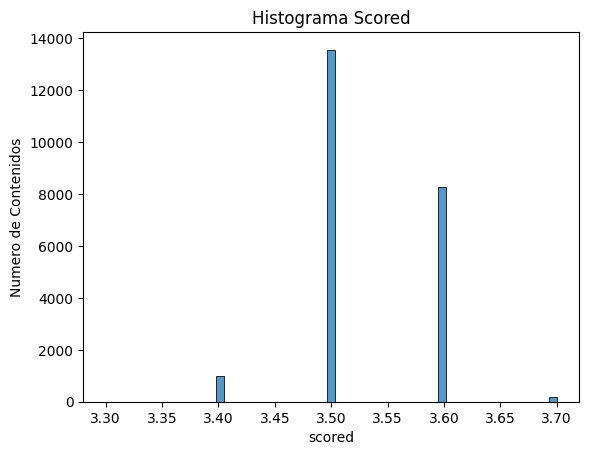

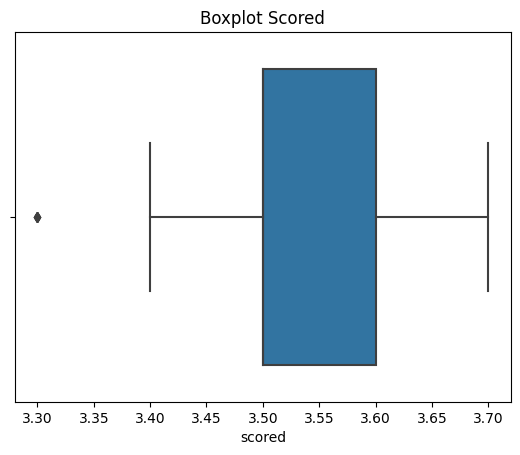

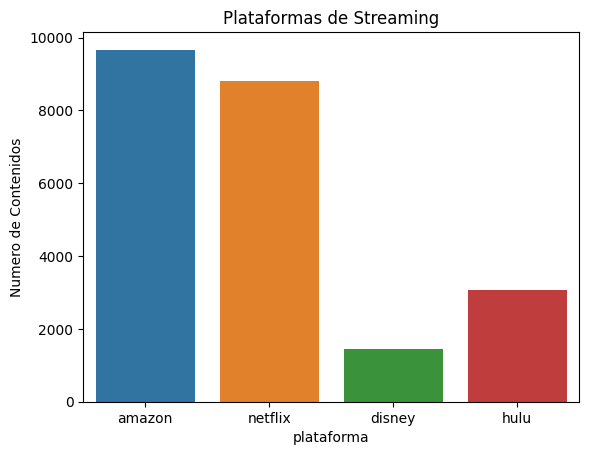

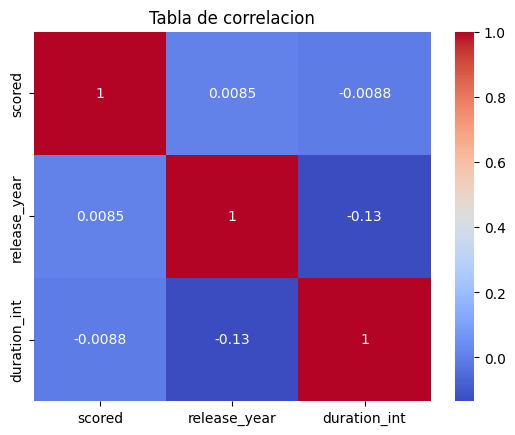

In [5]:
# Histogramas de las variables relevantes
sns.histplot(data=df, x="scored")
plt.title('Histograma Scored')
plt.ylabel('Numero de Contenidos')
plt.show()

# Boxplot de las variables relevantes
sns.boxplot(data=df, x="scored")
plt.title('Boxplot Scored')
plt.show()

# Gráfico de barras de la plataforma de streaming
sns.countplot(data=df, x="plataforma")
plt.title('Plataformas de Streaming')
plt.ylabel('Numero de Contenidos')
plt.show()

# Heatmap de las correlaciones entre variables numéricas
plt.title('Tabla de correlacion')
sns.heatmap(df[["scored", "release_year", "duration_int"]].corr(), annot=True, cmap="coolwarm")
plt.show()

### _Transformaciones_

In [6]:
# Rellenamos los datos nulos de la columna description con 'sin dato'
df['description'].fillna('sin dato', inplace=True)

### _Modelo De Recomendación_

In [7]:
# Clasificamos los datos con los que vamos a trabajar
datos = ['title', 'listed_in', 'description']
filtro = df[datos][:5000]

In [8]:
# Exportamos estos datos, ya que estos son los que nos sirven para hacer recomendaciones, esto porque
# no podemos utilizar todos los datos por falta de recursos
filtro.to_csv('datos_para_probarML', encoding='utf-8', index=False)

In [9]:
# Crearemos una funcion para eliminar los espacios que puedan haber en nuestros datos
def limpiar_data(x):
    return (x.replace(" ", ""))

In [10]:
# Aplicamos la funcion a nuestros datos
for i in datos:
    filtro[i] = filtro[i].apply(limpiar_data)

filtro.head()

,title,listed_in,description
0,thegrandseduction,"comedy,drama",asmallfishingvillagemustprocurealocaldoctortos...
1,takecaregoodnight,"drama,international",ametrofamilydecidestofightacybercriminalthreat...
2,secretsofdeception,"action,drama,suspense",afteramandiscovershiswifeischeatingonhimwithan...
3,pink:stayingtrue,documentary,"pinkbreaksthemoldonceagain,bringinghercareerto..."
4,monstermaker,"drama,fantasy",teenagemattbantingwantstoworkwithafamousbutecc...


In [11]:
# Creamos una cadena para contener los metados que alimentaran a nuestro a vector
def cadena(x):
    return x['title'] + ' ' + x['listed_in'] + ' ' + x['description'] 

filtro['data'] = filtro.apply(cadena, axis=1)

In [12]:
# Importamos CountVectorizer de sklearn y luego crear nuestra matrix
from sklearn.feature_extraction.text import CountVectorizer

conteo = CountVectorizer(stop_words='english')
conteo_matrix = conteo.fit_transform(filtro['data'])

In [13]:
# Ahora calculamos la matriz de similitud de coseno basada en la cuenta_matrix
from sklearn.metrics.pairwise import cosine_similarity

cos_sim = cosine_similarity(conteo_matrix, conteo_matrix)

In [14]:
# Aqui reconstruimos el dataset original para obtener los indices
filtro = filtro.reset_index()
indices = pd.Series(filtro.index, index=filtro['title'])

In [15]:
# Creamos nuestra funcion para recomendar, la cual esta integrada en la API
def get_recomendacion (title):
    title = title.replace(' ', '').lower()
    idx = indices[title]

    # Obtenemos las puntuaciones de similitud de peliculas con la pelicula ingresada
    sim_score = list(enumerate(cos_sim[idx]))

    # Ordenamos las peliculas segun la puntuacion de similitud
    sim_score = sorted(sim_score, key=lambda x: x[1], reverse=True)

    # Obtenemos las puntuaciones de las 5 peliculas mas similares 
    sim_score = sim_score[1:6]

    # Obtenemos los indices de peliculas
    pelicula_indice = [i[0] for i in sim_score]

    # Obtenemos el nombre de las peliculas
    respuesta = df['title'].iloc[pelicula_indice]
    respuesta = [i for i in respuesta]
    return respuesta

In [16]:
# Pedimos una recomendacion 
get_recomendacion('the grand seduction')

['waiting on mary',
 'series_project_un_test_uhd',
 'digging to china',
 'la cucaracha',
 'the intervention']